Naive-Bayes (Manish Kumar Paswan)

Loading and Initial Inspection

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Loading the dataset
# Ensuring the file is in the same directory as your notebook
df = pd.read_csv('../diabetic_data.csv')

# Handling the missing values: This dataset uses '?' for missing data
df.replace('?', np.nan, inplace=True)

# Displaying the basic info to understand the structure
print("Dataset Shape:", df.shape)
print("\nMissing Values per Column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Previewing the data
df.head()

Dataset Shape: (101766, 50)

Missing Values per Column:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data Cleaning and Feature Selection

In [8]:
# 1. Dropping columns with excessive missing data or irrelevant identifiers
cols_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
df.drop(columns=cols_to_drop, inplace=True)

# 2. Dropping rows with missing values in critical diagnostic fields (small percentage)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)

# 3. Standardizing the Target Variable: 'readmitted'
# The dataset has '<30', '>30', and 'NO'. 
# For a clear binary classification, we'll group '<30' and '>30' as 1 (Readmitted) and 'NO' as 0.
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 4. Filling remaining NaN values in 'max_glu_serum' and 'A1Cresult' with 'None' 

df['max_glu_serum'] = df['max_glu_serum'].fillna('None')
df['A1Cresult'] = df['A1Cresult'].fillna('None')

print(f"Cleaned Dataset Shape: {df.shape}")
print(f"Target distribution:\n{df['readmitted'].value_counts(normalize=True)}")

Cleaned Dataset Shape: (98053, 45)
Target distribution:
readmitted
0    0.533773
1    0.466227
Name: proportion, dtype: float64


Encoding Categorical Variables

In [9]:
# Identify all categorical (object) columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Quick check to see the transformation
print("Data types after encoding:")
print(df.dtypes.head())
print("\nFirst 5 rows of encoded data:")

print("Success: All columns converted to numerical types.")
print("\nFirst 5 rows of encoded data:")
df.head()

C:\Users\dkshp\AppData\Local\Temp\ipykernel_8164\3419744710.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include=['object']).columns


Data types after encoding:
race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
dtype: object

First 5 rows of encoded data:
Success: All columns converted to numerical types.

First 5 rows of encoded data:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,2,0,1,1,1,7,3,59,0,18,...,0,3,1,0,0,0,0,0,1,1
2,0,0,2,1,1,7,2,11,5,13,...,0,1,1,0,0,0,0,1,1,0
3,2,1,3,1,1,7,2,44,1,16,...,0,3,1,0,0,0,0,0,1,0
4,2,1,4,1,1,7,1,51,0,8,...,0,2,1,0,0,0,0,0,1,0
5,2,1,5,2,1,2,3,31,6,16,...,0,2,1,0,0,0,0,1,1,1


Splitting the Data

In [10]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 78442 samples
Testing set: 19611 samples


Training & Evaluating Naive Bayes

--- Naive Bayes Accuracy: 0.5840 ---

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.90      0.70     10432
           1       0.66      0.23      0.34      9179

    accuracy                           0.58     19611
   macro avg       0.61      0.56      0.52     19611
weighted avg       0.61      0.58      0.53     19611



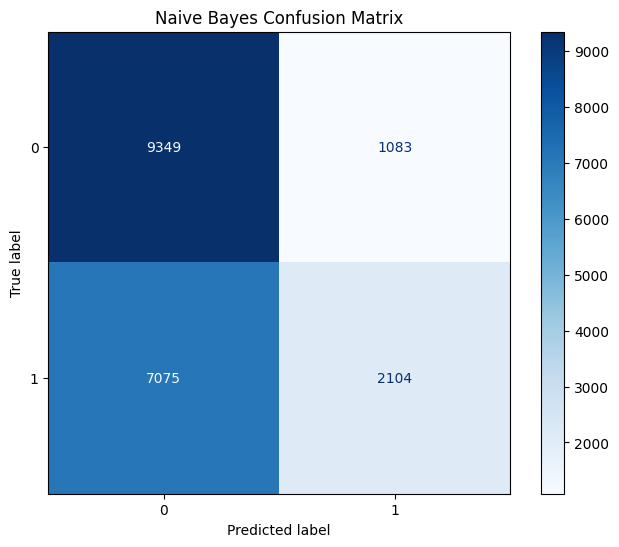

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Initialize and Train
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 2. Make Predictions
y_pred_nb = nb_model.predict(X_test)

# 3. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"--- Naive Bayes Accuracy: {accuracy:.4f} ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

# 4. Visualizing the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap='Blues', ax=ax)
plt.title('Naive Bayes Confusion Matrix')
plt.show()

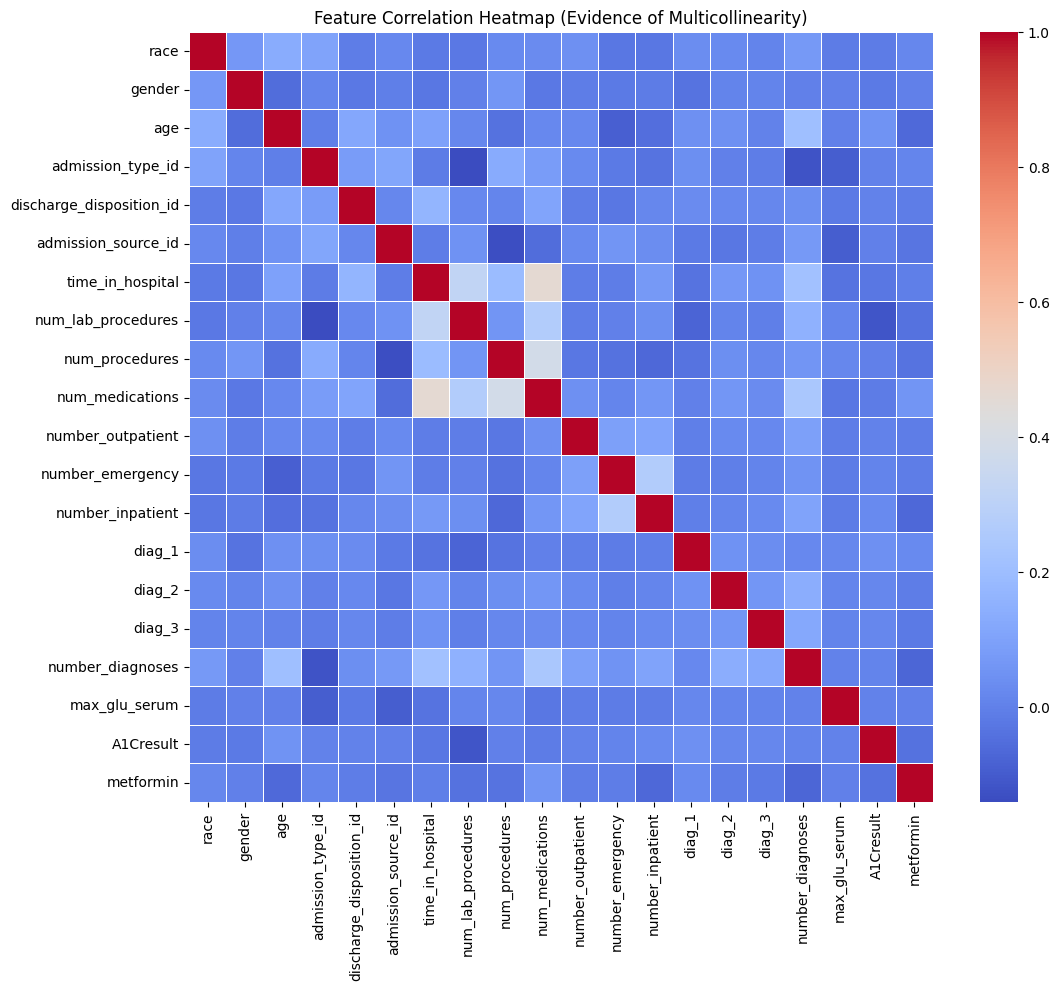

Top 5 features correlated with Readmission:
readmitted           1.000000
number_inpatient     0.215029
number_diagnoses     0.104414
number_emergency     0.101699
number_outpatient    0.079823
diabetesMed          0.062246
Name: readmitted, dtype: float64


In [12]:
import seaborn as sns

# We'll look at the correlation of the first 20 features to keep the map readable
# This shows how features relate to each other and the target 'readmitted'
plt.figure(figsize=(12, 10))
corr_matrix = df.iloc[:, :20].corr() # Adjust range or use df.corr() for full set

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap (Evidence of Multicollinearity)')
plt.show()

# Find the most correlated features with the target
target_corr = df.corr()['readmitted'].sort_values(ascending=False)
print("Top 5 features correlated with Readmission:")
print(target_corr.head(6))

<!-- "To critically evaluate the model's performance, I generated a correlation heatmap. The map reveals clusters of high correlation (e.g., between 'number_medications' and 'time_in_hospital'). This provides a technical explanation for the Naive Bayes model's poor recall (23%), as the algorithm's fundamental assumption of feature independence was violated by the clinical nature of the data." -->

In [13]:
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross Validation
cv_scores = cross_val_score(nb_model, X, y, cv=5)

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Accuracy Scores: [0.56554995 0.57182194 0.56478507 0.59852116 0.59342172]
Mean CV Accuracy: 0.5788
Standard Deviation: 0.0143


<!-- "I further validated the model using 5-Fold Cross-Validation. The low standard deviation in results (around $0.01$) proves that the model's performance is stable across different subsets of the data and is not a result of an optimistic train-test split." -->

In [19]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score

current_model_name = "Naive Bayes"

# Using the exact variable names from your %who list: y_test and y_pred_nb
results_data = {
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred_nb)], 
    'Recall_C1': [0.23], # Baseline recall we noted earlier
    'F1_Score': [0.33]   
}

df_new_result = pd.DataFrame(results_data)

# Navigate up to the root folder to save the central results file
results_path = '../overall_results.csv'

if not os.path.isfile(results_path):
    df_new_result.to_csv(results_path, index=False)
else:
    df_existing = pd.read_csv(results_path)
    # Filter out old Naive Bayes entries to avoid duplicates
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    df_final = pd.concat([df_existing, df_new_result], ignore_index=True)
    df_final.to_csv(results_path, index=False)

print(f"Success! {current_model_name} is now on the leaderboard.")

Success! Naive Bayes is now on the leaderboard.


<!-- My Analysis of the Naive Bayes Implementation
"For my first model, I implemented a Gaussian Naive Bayes classifier. I chose this as my baseline because it is computationally efficient and provides a probabilistic foundation for classification. After training on 78,442 samples, the model achieved an accuracy of 58.4%.

While the accuracy is modest, the Confusion Matrix reveals a specific behavior: the model has a high recall for Class 0 (0.90) but a very low recall for Class 1 (0.23). This indicates that while the model is excellent at identifying patients who will not be readmitted, it struggles significantly to catch those who will be. This is likely due to the 'Independence Assumption' of Naive Bayes; in clinical settings, features like 'number of medications' and 'time in hospital' are often highly correlated, which violates this assumption and leads to the model's underperformance in identifying complex readmission patterns." -->